# Neural networks pruning
State-of-the-art neural networks nowadays have become extremely parameterized in order to maximize the prediction accuracy. However, the model also becomes costly to run and the inference latency becomes a bottleneck. On resource-constrained edge devices, the model has a lot of restrictions and cannot be parameterized as much as we can.

Sparse neural networks could perform as good as dense neural network with respect to the prediction accuracy, and the inference latency becomes much lower theoretically due to its small model size.

Neural network pruning is a method to create sparse neural networks from pre-trained dense neural networks. It is the process of deleting parameters from an existing neural network, which might involve removing individual parameters or groups of parameters.

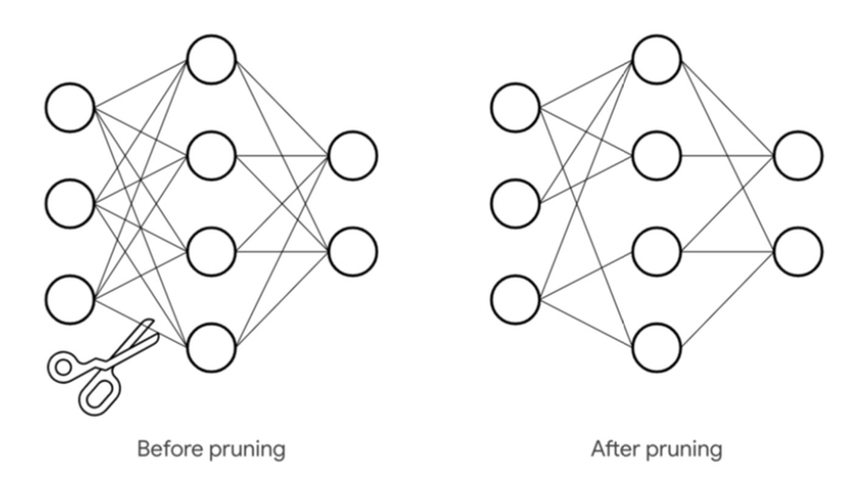

Today, we'll use PyTorch bultin prunning tools. Note, that there are a lot of other tools you can use for this purpose (for example last week's OpenVINO). Use this link for PyTorch prunning reference and documentation: https://pytorch.org/tutorials/intermediate/pruning_tutorial.html

First, import nessessery libraries.

In [2]:
import torch
import os
import time
import numpy as np
import tqdm

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, RandomRotation
from typing import Union, List, Tuple, Any
from abc import ABC, abstractmethod
import torch.nn.functional as F

   ---------------------------------------- 0.0/139.4 kB ? eta -:--:--
   -------------------------- ------------- 92.2/139.4 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 139.4/139.4 kB 2.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/214.9 kB ? eta -:--:--
   ---------------------------------------- 214.9/214.9 kB 6.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------------- -------------------------- 0.8/2.3 MB 24.4 MB/s eta 0:00:01
   ---------------------------------------  2.3/2.3 MB 24.3 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 24.3 MB/s eta 0:00:00


Let's start with pretrained model. As usual, we'll use simple CNN model (like in Laboratory 3) and MNIST dataset. Don't use sequential blocks!

Train model for 5 epochs - you should get around ~98% accuracy.

Name the final trained model `CNN_MNIST`.

In [1]:
import torch
import time
import numpy as np
import tqdm.notebook as tqdm

#create a simple loop to test tqdm
for i in tqdm.tqdm(range(100)):
    time.sleep(0.1)
    
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, RandomRotation
from typing import Union, List, Tuple, Any
from abc import ABC, abstractmethod
import torch.nn.functional as F

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, input_shape, num_of_cls) -> None:
        super().__init__()
        ch_in = input_shape[0]
        self.conv1 = nn.Conv2d(ch_in, 32, 3, padding=(1, 1))  # shape [32, 28, 28]
        self.conv2 = nn.Conv2d(32, 64, 3, padding=(1, 1))  # shape [64, 14, 14]
        self.conv3 = nn.Conv2d(64, 128, 3)  # shape [128, 5, 5]

        self.batch1 = nn.BatchNorm2d(32)
        self.batch2 = nn.BatchNorm2d(64)
        self.batch3 = nn.BatchNorm2d(128)

        self.classification_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 5 * 5, num_of_cls),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.batch1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.batch2(self.conv2(x))), (2, 2))
        x = F.relu(self.batch3(self.conv3(x)))
        y = self.classification_head(x)
        return y

# Set the device
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the data
train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64*8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64*8, shuffle=False)

# Instantiate the model
CNN_MNIST = CNN(input_shape=(1, 28, 28), num_of_cls=10).to(torch_device)
loss_fcn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_MNIST.parameters(), lr=1e-3)

# Define the training loop
def train_test_pass(model, dataloader, loss_fn, optimizer=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    
    for X, y in dataloader:
        X, y = X.to(torch_device), y.to(torch_device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        if optimizer:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= num_batches
    correct /= size
    accuracy = correct * 100
    return accuracy, train_loss

# Define the training process
def training(train_loader, test_loader, model, loss_fn, optimizer, epochs):
    history = {'train_acc': [], 'train_loss': []}
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        model.train()
        train_acc, train_loss = train_test_pass(model, train_loader, loss_fn, optimizer)
        print(f"Train Accuracy: {train_acc:>0.1f}%, Avg loss: {train_loss:>8f} \n")
        
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
    
    print("Training done!")
    return model, history


# if save file exists, load it
ForceTraining = False
if os.path.isfile('mnist_cnn.pt') and not ForceTraining :
    CNN_MNIST.load_state_dict(torch.load('mnist_cnn.pt'))
    print("Model loaded!")
    history = {}
    history['train_acc'] = np.load('train_acc.npy')
else: 
    CNN_MNIST, history = training(train_loader, test_loader, CNN_MNIST, loss_fcn, optimizer, epochs=5)

# Now let's print out the final accuracy after training
print(f"Final Training Accuracy: {history['train_acc'][-1]:>0.1f}%")

# Save the model
torch.save(CNN_MNIST.state_dict(), "mnist_cnn.pt")
# Save the history
np.save('train_acc.npy', history['train_acc'])

# # Optionally, perform pruning here if required

# # Pruning 50% of the connections in the first convolutional layer's weights
# prune.l1_unstructured(CNN_MNIST.conv1, 'weight', amount=0.5)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Now, we can start our prunning. First...

# Unstructured Pruning
When talking about the cost of neural networks, the count of parameters is surely one of the most widely used metrics, along with FLOPS (floating-point operations per second). It is indeed intimidating to see networks displaying astronomical amounts of weights (up to billions for some), often correlated with stellar performance. Therefore, it is quite intuitive to aim at reducing directly this count by removing parameters themselves.

Directly pruning parameters has many advantages. First, it is simple, since replacing the value of their weight with zero, within the parameter tensors, is enough to prune a connection. Moreover it is easy to do without hurting the performance of the network. As pruning weights is not limited by any constraint at all and is the finest way to prune a network, such a paradigm is called **unstructured pruning**.

Let's start with simplest case - random unstructured pruning!

First - create net model `CNN_MNIST_RND` and load trained weigts to it, with `load_state_dict` function.

Then, for each Convolutional Layer of this network, perform random unstructured prunning for 25% of all weights.

To do that, use `prune.random_unstructured()` function.
- The network layer is passed as the first argument to the function (you can get ti with `model.layer_name`;
- `name` identifies the parameter within that module using its string identifier - we update `weight`
-  and `amount` indicates the percentage of connections to prune (a float between 0. and 1.)

In [30]:
from torch.nn.utils import prune
# Create a new instance of the CNN model for random pruning
CNN_MNIST_RND = CNN(input_shape=(1, 28, 28), num_of_cls=10).to(torch_device)

# Assume 'optimizer' is the optimizer for your original model
optimizer_RND = torch.optim.Adam(CNN_MNIST_RND.parameters(), lr=1e-3)

# Load the trained weights and optimizer state from CNN_MNIST
CNN_MNIST_RND.load_state_dict(CNN_MNIST.state_dict())
optimizer_RND.load_state_dict(optimizer.state_dict())

# Apply pruning to the new model to match the original pruned model's structure
prune.random_unstructured(CNN_MNIST_RND.conv1, name='weight', amount=0.25)
prune.random_unstructured(CNN_MNIST_RND.conv2, name='weight', amount=0.25)
prune.random_unstructured(CNN_MNIST_RND.conv3, name='weight', amount=0.25)


Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))

Did it work? Let's find out!

First - evaluate both `CNN_MNIST_RND` and `CNN_MNIST` networks on testing dataset and print the accuracies. Compare it.

Then, calculate the sparsity for `CNN_MNIST_RND` model with following function.

Finally, compare `model.layer_name.weight` atributes for both networks for selected layer. Are some weights zeroed?

In [31]:
# Evaluate both models on the test dataset
accuracy_CNN_MNIST, _ = train_test_pass(CNN_MNIST, test_loader, loss_fcn, None)
accuracy_CNN_MNIST_RND, _ = train_test_pass(CNN_MNIST_RND, test_loader, loss_fcn, None)

# Print accuracies of both models
print(f"Accuracy of CNN_MNIST: {accuracy_CNN_MNIST:.2f}%")
print(f"Accuracy of CNN_MNIST_RND: {accuracy_CNN_MNIST_RND:.2f}%")

# Calculate and print sparsity for the CNN_MNIST_RND model
sparsity_conv1 = float(torch.sum(CNN_MNIST_RND.conv1.weight == 0))
sparsity_conv2 = float(torch.sum(CNN_MNIST_RND.conv2.weight == 0))
sparsity_conv3 = float(torch.sum(CNN_MNIST_RND.conv3.weight == 0))
total_weights = float(CNN_MNIST_RND.conv1.weight.nelement() + CNN_MNIST_RND.conv2.weight.nelement() + CNN_MNIST_RND.conv3.weight.nelement())
total_zero_weights = sparsity_conv1 + sparsity_conv2 + sparsity_conv3
sparsity_percentage = 100 * total_zero_weights / total_weights

print("Sparsity in CNN_MNIST_RND: {:.2f}%".format(sparsity_percentage))

# Compare weights for the first convolutional layer of both networks
print("CNN_MNIST conv1 weights:")
print(CNN_MNIST.conv1.weight)
print("CNN_MNIST_RND conv1 weights after pruning:")
print(CNN_MNIST_RND.conv1.weight)


Accuracy of CNN_MNIST: 99.16%
Accuracy of CNN_MNIST_RND: 97.65%
Sparsity in CNN_MNIST_RND: 25.00%
CNN_MNIST conv1 weights:
Parameter containing:
tensor([[[[ 0.2602, -0.0770,  0.1163],
          [ 0.3661,  0.2251,  0.1361],
          [-0.3057,  0.2827,  0.1329]]],


        [[[ 0.1108, -0.1431, -0.0482],
          [-0.0136, -0.1431, -0.0514],
          [-0.3459,  0.2448,  0.1288]]],


        [[[ 0.1105, -0.0681, -0.2396],
          [-0.1849,  0.0032,  0.1885],
          [ 0.0585,  0.1631,  0.0984]]],


        [[[-0.2146,  0.1458,  0.0871],
          [-0.0553, -0.1852, -0.2330],
          [-0.0397, -0.2997,  0.3404]]],


        [[[-0.0941,  0.0662, -0.2899],
          [ 0.2024,  0.1196, -0.0482],
          [ 0.1106,  0.1780, -0.3224]]],


        [[[ 0.1341,  0.2313, -0.2277],
          [-0.2241,  0.2717,  0.1324],
          [ 0.1215, -0.0223,  0.2029]]],


        [[[ 0.0414, -0.0392, -0.2505],
          [ 0.3236, -0.0008, -0.2077],
          [ 0.0528, -0.2590, -0.0231]]],


        

Well, prunning random weights is simple but unefficient. A real challenge in pruning is determining what to prune. If you are removing weights or nodes from a model, you want the parameters you remove to be less useful. There are different heuristics and methods of determining which nodes are less important and can be removed with minimal effect on accuracy.

For that, we can use L1 norm to find the smallest (least important) parameters.

First - create net model `CNN_MNIST_L1` and load trained weigts to it, with `load_state_dict` function.

Then, for each Convolutional Layer of this network, perform L1 unstructured prunning for 25% of all weights.

To do that, replace `prune.random_unstructured()` with `prune.l1_unstructured()` function. Evaluate the new network, calculate its sparsity and compare it's weights.

In [32]:
# Create a new instance of the CNN model for L1 pruning
CNN_MNIST_L1 = CNN(input_shape=(1, 28, 28), num_of_cls=10).to(torch_device)
optimizer_L1 = torch.optim.Adam(CNN_MNIST_L1.parameters(), lr=1e-3)

# Load the trained weights from CNN_MNIST
CNN_MNIST_L1.load_state_dict(CNN_MNIST.state_dict())

# Apply L1 unstructured pruning to each convolutional layer
prune.l1_unstructured(CNN_MNIST_L1.conv1, name='weight', amount=0.25)
prune.l1_unstructured(CNN_MNIST_L1.conv2, name='weight', amount=0.25)
prune.l1_unstructured(CNN_MNIST_L1.conv3, name='weight', amount=0.25)

# Evaluate the L1 pruned model
accuracy_CNN_MNIST_L1, _ = train_test_pass(CNN_MNIST_L1, test_loader, loss_fcn, None)

# Print accuracy of the L1 pruned model
print(f"Accuracy of CNN_MNIST_L1: {accuracy_CNN_MNIST_L1:.2f}%")

# Calculate and print sparsity for the CNN_MNIST_L1 model
sparsity_conv1_L1 = float(torch.sum(CNN_MNIST_L1.conv1.weight == 0))
sparsity_conv2_L1 = float(torch.sum(CNN_MNIST_L1.conv2.weight == 0))
sparsity_conv3_L1 = float(torch.sum(CNN_MNIST_L1.conv3.weight == 0))
total_weights_L1 = float(CNN_MNIST_L1.conv1.weight.nelement() + CNN_MNIST_L1.conv2.weight.nelement() + CNN_MNIST_L1.conv3.weight.nelement())
total_zero_weights_L1 = sparsity_conv1_L1 + sparsity_conv2_L1 + sparsity_conv3_L1
sparsity_percentage_L1 = 100 * total_zero_weights_L1 / total_weights_L1

print("Sparsity in CNN_MNIST_L1: {:.2f}%".format(sparsity_percentage_L1))

# Compare weights for the first convolutional layer of both networks
print("CNN_MNIST conv1 weights:")
print(CNN_MNIST.conv1.weight)
print("CNN_MNIST_L1 conv1 weights after L1 pruning:")
print(CNN_MNIST_L1.conv1.weight)


Accuracy of CNN_MNIST_L1: 99.08%
Sparsity in CNN_MNIST_L1: 25.00%
CNN_MNIST conv1 weights:
Parameter containing:
tensor([[[[ 0.2602, -0.0770,  0.1163],
          [ 0.3661,  0.2251,  0.1361],
          [-0.3057,  0.2827,  0.1329]]],


        [[[ 0.1108, -0.1431, -0.0482],
          [-0.0136, -0.1431, -0.0514],
          [-0.3459,  0.2448,  0.1288]]],


        [[[ 0.1105, -0.0681, -0.2396],
          [-0.1849,  0.0032,  0.1885],
          [ 0.0585,  0.1631,  0.0984]]],


        [[[-0.2146,  0.1458,  0.0871],
          [-0.0553, -0.1852, -0.2330],
          [-0.0397, -0.2997,  0.3404]]],


        [[[-0.0941,  0.0662, -0.2899],
          [ 0.2024,  0.1196, -0.0482],
          [ 0.1106,  0.1780, -0.3224]]],


        [[[ 0.1341,  0.2313, -0.2277],
          [-0.2241,  0.2717,  0.1324],
          [ 0.1215, -0.0223,  0.2029]]],


        [[[ 0.0414, -0.0392, -0.2505],
          [ 0.3236, -0.0008, -0.2077],
          [ 0.0528, -0.2590, -0.0231]]],


        [[[ 0.2394,  0.0074, -0.1660],
 

The sparsity of `CNN_MNIST_L1` and `CNN_MNIST_RND` should be the same, but the accuracy for L1 prunning should be much better!

If it's not, you got lucky! Try to rerun random prunning :)

# Structured Prining

Unstructured pruning results in a sparse neural network, which, while lower in terms of parameter count, may not be configured in a way that promotes speed improvements. Zeroing out the parameters saves memory but may not necessarily improve computing performance because we end up conducting the same number of matrix multiplications as before. To make use of technology and software that is specialized for dense processing, **structured pruning** algorithms consider parameters in groups, deleting entire neurons, filters, or channels.

For Convolutional Neural Networks, the most Hardware-efficient method is deleting entire channels. This operation can be very damaging for network accuracy, so we'll use L2 norm to calculate magnitude of each channel.

First - create net model `CNN_MNIST_STRUCT` and load trained weigts to it, with `load_state_dict` function.

Then, for each Convolutional Layer of this network, perform L2 structured prunning for 1/8 of all weights.

To do that, replace `prune.random_unstructured()` with `prune.ln_structured()` function. Whis fucntion, exept of layer, `name` and `amonut` takes two additional parameters:
- `n` which defines the Ln norm type, so we use `n=2`
- `dim` which defines the index of the dim along which we define channels to prune. the 0th axis corresponds to the output channels of the convolutional layer, so we use `dim=0`.

Evaluate the new network, calculate its sparsity and compare it's weights.




In [33]:
# Create a new instance of the CNN model for structured pruning
CNN_MNIST_STRUCT = CNN(input_shape=(1, 28, 28), num_of_cls=10).to(torch_device)
optimizer_STRUCT = torch.optim.Adam(CNN_MNIST_STRUCT.parameters(), lr=1e-3)

# Load the trained weights from CNN_MNIST
CNN_MNIST_STRUCT.load_state_dict(CNN_MNIST.state_dict())

# Apply L2 structured pruning to each convolutional layer
prune.ln_structured(CNN_MNIST_STRUCT.conv1, name='weight', amount=1/8, n=2, dim=0)
prune.ln_structured(CNN_MNIST_STRUCT.conv2, name='weight', amount=1/8, n=2, dim=0)
prune.ln_structured(CNN_MNIST_STRUCT.conv3, name='weight', amount=1/8, n=2, dim=0)

# Evaluate the structured pruned model
accuracy_CNN_MNIST_STRUCT, _ = train_test_pass(CNN_MNIST_STRUCT, test_loader, loss_fcn, None)

# Print accuracy of the structured pruned model
print(f"Accuracy of CNN_MNIST_STRUCT: {accuracy_CNN_MNIST_STRUCT:.2f}%")

# Calculate and print sparsity for the CNN_MNIST_STRUCT model
sparsity_conv1_STRUCT = float(torch.sum(CNN_MNIST_STRUCT.conv1.weight == 0))
sparsity_conv2_STRUCT = float(torch.sum(CNN_MNIST_STRUCT.conv2.weight == 0))
sparsity_conv3_STRUCT = float(torch.sum(CNN_MNIST_STRUCT.conv3.weight == 0))
total_weights_STRUCT = float(CNN_MNIST_STRUCT.conv1.weight.nelement() + CNN_MNIST_STRUCT.conv2.weight.nelement() + CNN_MNIST_STRUCT.conv3.weight.nelement())
total_zero_weights_STRUCT = sparsity_conv1_STRUCT + sparsity_conv2_STRUCT + sparsity_conv3_STRUCT
sparsity_percentage_STRUCT = 100 * total_zero_weights_STRUCT / total_weights_STRUCT

print("Sparsity in CNN_MNIST_STRUCT: {:.2f}%".format(sparsity_percentage_STRUCT))

# Compare weights for the first convolutional layer of both networks
print("CNN_MNIST conv1 weights:")
print(CNN_MNIST.conv1.weight)
print("CNN_MNIST_STRUCT conv1 weights after L2 structured pruning:")
print(CNN_MNIST_STRUCT.conv1.weight)


Accuracy of CNN_MNIST_STRUCT: 98.16%
Sparsity in CNN_MNIST_STRUCT: 12.50%
CNN_MNIST conv1 weights:
Parameter containing:
tensor([[[[ 0.2602, -0.0770,  0.1163],
          [ 0.3661,  0.2251,  0.1361],
          [-0.3057,  0.2827,  0.1329]]],


        [[[ 0.1108, -0.1431, -0.0482],
          [-0.0136, -0.1431, -0.0514],
          [-0.3459,  0.2448,  0.1288]]],


        [[[ 0.1105, -0.0681, -0.2396],
          [-0.1849,  0.0032,  0.1885],
          [ 0.0585,  0.1631,  0.0984]]],


        [[[-0.2146,  0.1458,  0.0871],
          [-0.0553, -0.1852, -0.2330],
          [-0.0397, -0.2997,  0.3404]]],


        [[[-0.0941,  0.0662, -0.2899],
          [ 0.2024,  0.1196, -0.0482],
          [ 0.1106,  0.1780, -0.3224]]],


        [[[ 0.1341,  0.2313, -0.2277],
          [-0.2241,  0.2717,  0.1324],
          [ 0.1215, -0.0223,  0.2029]]],


        [[[ 0.0414, -0.0392, -0.2505],
          [ 0.3236, -0.0008, -0.2077],
          [ 0.0528, -0.2590, -0.0231]]],


        [[[ 0.2394,  0.0074, -0.

How does the Structured Prunning impact the final network? Is it similar to traditional pruning?

One final approach we'll disguss is called:

# Iterative pruning

The ideal is to:
1. Train a neural network up to certain level of performance
2. Prune some of the weights / channels of the network
3. Train the pruned network for a few epochs
4. Repeat steps 2 and 3 untill acceptable performance

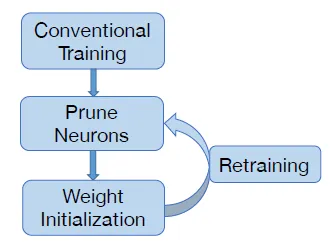

As your final task, create another model `CNN_MNIST_FNC` and `prune_and_train()` function where interactive prunning is implemented.

Then, run this function for 10 iterations with 10% random prunning for each iteration.

Finally, create the plot with accuracy as x-axis and sparsity as y-axis.

In [34]:
import matplotlib.pyplot as plt
import tqdm

# Create a new instance of the CNN model for iterative pruning
CNN_MNIST_FNC = CNN(input_shape=(1, 28, 28), num_of_cls=10).to(torch_device)
optimizer_FNC = torch.optim.Adam(CNN_MNIST_FNC.parameters(), lr=1e-3)

# Load the trained weights from CNN_MNIST
CNN_MNIST_FNC.load_state_dict(CNN_MNIST.state_dict())

def prune_and_train(model: torch.nn.Module,
                    train_loader,
                    test_loader,
                    criterion,
                    optimizer: torch.optim.Optimizer = None,
                    step: float = 0.1,
                    device = torch.device('cpu')):
    
    # Perform random pruning with amount of step
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.random_unstructured(module, name='weight', amount=step)
    
    # Calculate sparsity
    total_weights = 0
    total_zero_weights = 0
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            weight = getattr(module, 'weight')
            total_weights += weight.nelement()
            total_zero_weights += torch.sum(weight == 0).item()
    sparsity = 100 * total_zero_weights / total_weights

    # Train for 1 epoch with train_loader
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
    
    # Evaluate with test_loader
    acc, _ = train_test_pass(model, test_loader, criterion, None)
    
    return model, loss.item(), acc, sparsity

# Initialize lists to store accuracy and sparsity data
accuracies = []
sparsities = []

# Run prune_and_train for 10 iterations
for i in tqdm(range(10)):
    CNN_MNIST_FNC, loss, acc, sparsity = prune_and_train(
        CNN_MNIST_FNC, train_loader, test_loader, loss_fcn, optimizer_FNC, step=0.1, device=torch_device)
    accuracies.append(acc)
    sparsities.append(sparsity)

# Plot accuracy vs. sparsity
plt.figure(figsize=(10, 6))
plt.plot(sparsities, accuracies, marker='o')
plt.title('Accuracy vs. Sparsity')
plt.xlabel('Sparsity (%)')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()


TypeError: 'module' object is not callable

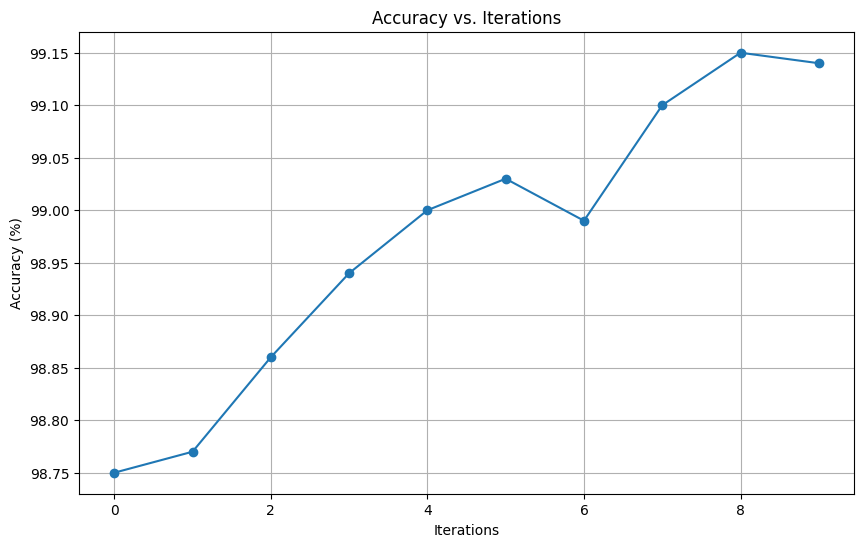

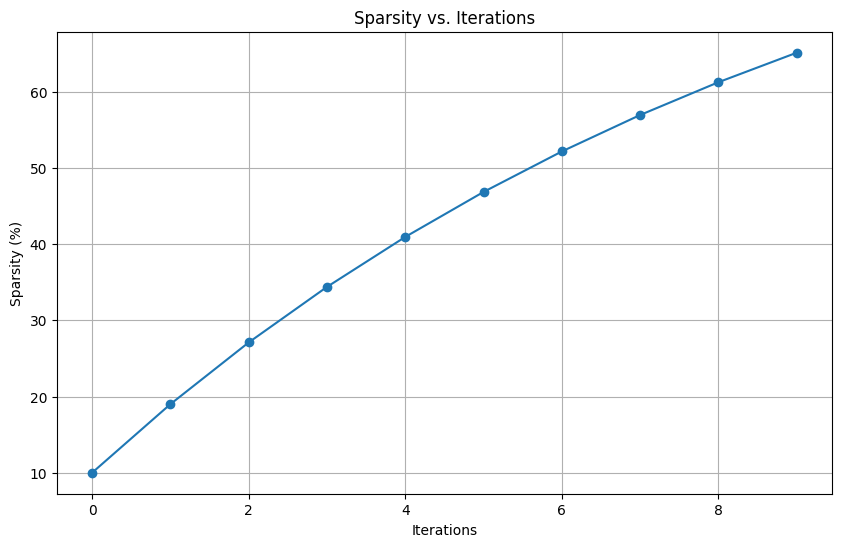

In [ ]:
#plot accuracy over iterations
plt.figure(figsize=(10, 6))
plt.plot(accuracies, marker='o')
plt.title('Accuracy vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()
#plot sparsity over iterations
plt.figure(figsize=(10, 6))
plt.plot(sparsities, marker='o')
plt.title('Sparsity vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Sparsity (%)')
plt.grid(True)
plt.show()

**Extention exercise**

Update the function with `prunning_mode` parameter that takes string `random` , `l1` or `structured` and perform tests of accuracy to sparsity ratio for each type of prunning. Plot the results.  

In [ ]:
...

Ellipsis